In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random


c:\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset (Modified for 1200x600 images)
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Split into satellite (left 600x600) and map (right 600x600)
        sat_img = image[:, :600, :]  # (H, 600, 3)
        map_img = image[:, 600:, :]  # (H, 600, 3)
        
        if self.transform:
            sat_img = self.transform(Image.fromarray(sat_img))
            map_img = self.transform(Image.fromarray(map_img))
            
        return sat_img, map_img

# U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        
        # Encoder
        self.enc1 = self.down_block(in_channels, 64, batchnorm=False)
        self.enc2 = self.down_block(64, 128)
        self.enc3 = self.down_block(128, 256)
        self.enc4 = self.down_block(256, 512)
        self.enc5 = self.down_block(512, 512)
        
        # Decoder
        self.dec1 = self.up_block(512, 512)
        self.dec2 = self.up_block(1024, 256)
        self.dec3 = self.up_block(512, 128)
        self.dec4 = self.up_block(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def down_block(self, in_channels, out_channels, batchnorm=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        
        # Decoder with skip connections
        d1 = self.dec1(e5)
        d1 = torch.cat([d1, e4], 1)
        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e3], 1)
        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e2], 1)
        d4 = self.dec4(d3)
        d4 = torch.cat([d4, e1], 1)
        
        return self.final(d4)

# PatchGAN Discriminator (Unchanged)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512 , 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 1)
        )

    def forward(self, img_A, img_B):
        combined = torch.cat([img_A, img_B], dim=1)
        return self.model(combined)

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training parameters
lr = 0.0002
beta1 = 0.5
lambda_pixel = 100
batch_size = 1
num_epochs = 300

# Transformations (Now resizes from 600x600 to 256x256)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset and DataLoader
dataset = Pix2PixDataset(root_dir="maps/train/", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss functions and optimizers
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [20]:

# Training loop
for epoch in range(num_epochs):
    for i, (sat_img, map_img) in enumerate(dataloader):
        real_A = sat_img.to(device)
        real_B = map_img.to(device)

        valid = torch.ones((real_A.size(0), 1 , 30, 30)).to(device)
        fake = torch.zeros((real_A.size(0), 1, 30, 30)).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        
        # Generate fake images
        fake_B = generator(real_A)
        
        # GAN loss
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        
        # Pixel-wise loss
        loss_pixel = criterion_pixel(fake_B, real_B)
        
        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)
        
        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)
        
        # Total loss
        loss_D = (loss_real + loss_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Print progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {loss_D.item():.6f}] [G loss: {loss_G.item():.6f}]")

# Save models
 

[Epoch 0/300] [Batch 0/500] [D loss: 0.846786] [G loss: 84.441750]
[Epoch 0/300] [Batch 100/500] [D loss: 0.380338] [G loss: 8.909870]
[Epoch 0/300] [Batch 200/500] [D loss: 0.612178] [G loss: 7.123557]
[Epoch 0/300] [Batch 300/500] [D loss: 0.275837] [G loss: 10.343338]
[Epoch 0/300] [Batch 400/500] [D loss: 0.292081] [G loss: 18.930704]
[Epoch 1/300] [Batch 0/500] [D loss: 0.750759] [G loss: 8.498769]
[Epoch 1/300] [Batch 100/500] [D loss: 0.145302] [G loss: 28.330282]
[Epoch 1/300] [Batch 200/500] [D loss: 0.278918] [G loss: 9.586803]
[Epoch 1/300] [Batch 300/500] [D loss: 0.730086] [G loss: 9.100361]
[Epoch 1/300] [Batch 400/500] [D loss: 0.276702] [G loss: 8.768145]
[Epoch 2/300] [Batch 0/500] [D loss: 0.294283] [G loss: 14.766986]
[Epoch 2/300] [Batch 100/500] [D loss: 1.263366] [G loss: 20.047235]
[Epoch 2/300] [Batch 200/500] [D loss: 0.458013] [G loss: 8.340966]
[Epoch 2/300] [Batch 300/500] [D loss: 0.720901] [G loss: 10.983398]
[Epoch 2/300] [Batch 400/500] [D loss: 0.440706

In [ ]:
# Save models
torch.save(generator.state_dict(), 'Pixpix_generator.pth')
torch.save(discriminator.state_dict(), 'Pixpix_discriminator.pth')


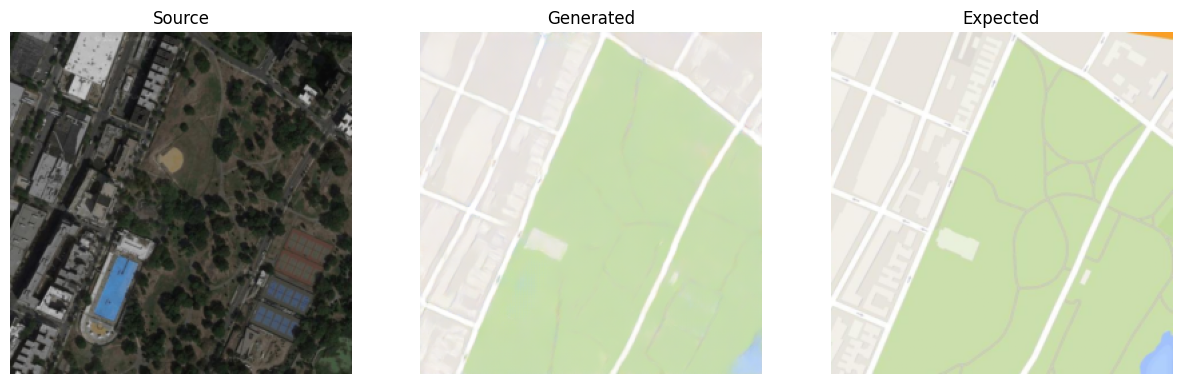

In [14]:
# Plotting function 
def plot_images(src_img, gen_img, tar_img):
    src_img = src_img.cpu().detach()
    gen_img = gen_img.cpu().detach()
    tar_img = tar_img.cpu().detach()
    
    images = torch.stack((src_img, gen_img, tar_img), dim=0)
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(titles[i])
    plt.show()

# Select a random example from the dataset
idx = random.randint(0, len(dataset) - 1)
src_image, tar_image = dataset[idx]

# Add batch dimension and move to device
src_image = src_image.unsqueeze(0).to(device)

# Generate image
with torch.no_grad():
    gen_image = generator(src_image)

# Prepare target image (add batch dim and move to device)
tar_image = tar_image.unsqueeze(0).to(device)

# Remove batch dimension before plotting
plot_images(src_image.squeeze(0), gen_image.squeeze(0), tar_image.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.8509804].


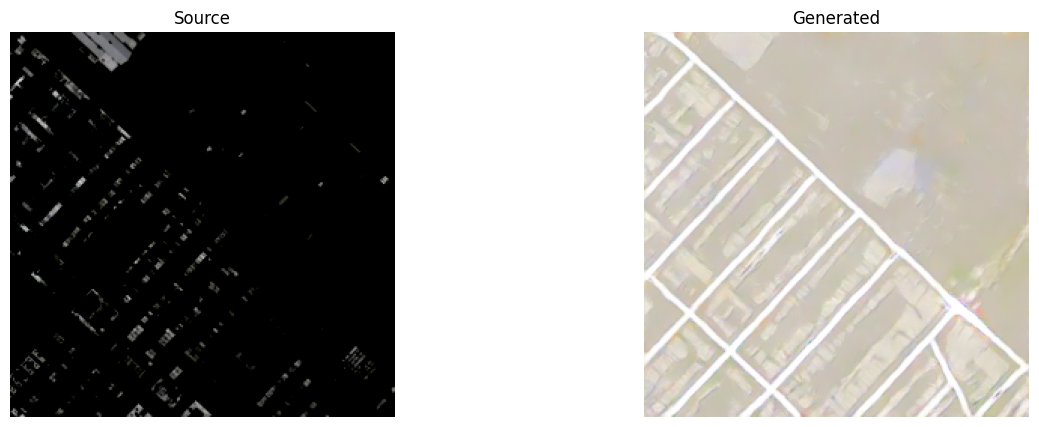

In [13]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the generator model
def load_generator(model_path, device):
    generator = UNetGenerator().to(device)  # Initialize your generator model
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()  # Set the model to evaluation mode
    return generator

# Preprocess the input image
def preprocess_image(image_path, device):
    image = Image.open(image_path).convert('RGB')
    
    if image.size == (1200, 600):
        # Split the image into satellite (left half) and map (right half)
        sat_img = image.crop((0, 0, 600, 600))  # Left half (satellite)
    else:
        # Resize the image to 256x256 for the model
        image = image.resize((256, 256))
        sat_img = image  # Use the whole image as input

    # Define the transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Apply the transform
    sat_img = transform(sat_img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return sat_img

# Generate the map using the generator
def generate_map(generator, image_path, device):
    sat_img = preprocess_image(image_path, device)

    with torch.no_grad():  # Disable gradient calculation
        gen_image = generator(sat_img)

    return gen_image

# Plotting function
def plot_images(src_img, gen_img, tar_img=None):
    src_img = src_img.cpu().detach()
    gen_img = gen_img.cpu().detach()
    
    images = [src_img, gen_img]
    titles = ['Source', 'Generated']
    
    if tar_img is not None:
        tar_img = tar_img.cpu().detach()
        images.append(tar_img)
        titles.append('Expected')

    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(titles[i])
    plt.show()

# Example usage
if __name__ == "__main__":
    model_path = 'Pixpix_generator.pth'  # Path to your saved generator model
    generator = load_generator(model_path, device)

    # Test image path (either a 1200x600 image or a random image)
    test_image_path = "maps/train/14.jpg"  # Update with your test image path

    # Generate the map
    gen_image = generate_map(generator, test_image_path, device)

    # Display the images
    # plot_images(preprocess_image(test_image_path, device).squeeze(0), gen_image.squeeze(0), tar_image)
    plot_images(preprocess_image(test_image_path, device).squeeze(0), gen_image.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9607843].


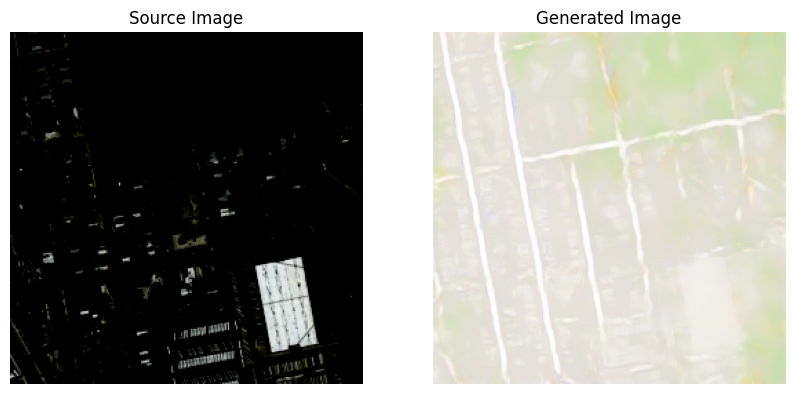

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Pix2Pix
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filenames = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Split into satellite (left 600x600) and map (right 600x600)
        sat_img = image[:, :600, :]  # (H, 600, 3)
        map_img = image[:, 600:, :]  # (H, 600, 3)
        
        if self.transform:
            sat_img = self.transform(Image.fromarray(sat_img))
            map_img = self.transform(Image.fromarray(map_img))
            
        return sat_img, map_img


# Load the generator model
def load_generator(model_path, device):
    generator = UNetGenerator().to(device)  # Initialize your generator model
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()  # Set the model to evaluation mode
    return generator

# Generate the map using the generator
def generate_map(generator, sat_img, device):
    with torch.no_grad():  # Disable gradient calculation
        gen_image = generator(sat_img)

    # Ensure values are within the range [0, 1]
    gen_image = (gen_image + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
    gen_image = torch.clamp(gen_image, 0, 1)  # Clip values to [0, 1]

    return gen_image

# Plotting function
def plot_images(src_img, gen_img):
    src_img = src_img.cpu().detach()
    gen_img = gen_img.cpu().detach()

    # Convert to NumPy array and change shape from (C, H, W) to (H, W, C)
    src_img_np = src_img.squeeze(0).numpy().transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
    gen_img_np = gen_img.squeeze(0).numpy().transpose(1, 2, 0)  # (C, H, W) to (H, W, C)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(src_img_np)
    plt.title('Source Image')

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(gen_img_np)
    plt.title('Generated Image')

    plt.show()

# Example usage
if __name__ == "__main__":
    model_path = 'Pixpix_generator.pth'  # Path to your saved generator model
    generator = load_generator(model_path, device)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load dataset
    dataset = Pix2PixDataset(root_dir="maps/val", transform=transform)  # Update with your image directory
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Get a random sample from the dataset
    for sat_img, _ in dataloader:
        sat_img = sat_img.to(device)  # Move to device
        break  # Get only the first sample

    # Generate the map
    gen_image = generate_map(generator, sat_img, device)

    # Plot the images
    plot_images(sat_img, gen_image)